In [286]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.patches as mpatches

# **Problem description**

Simple model $x = \theta + \epsilon \ \text{with}\ \epsilon\sim \mathcal{N}(0 ; \sigma^{2})\ ; \ \sigma^{2} = 0.01 \\$
Prior on theta
$$ p(\theta) = \mathcal{N}(\mu_0,\,\sigma_0^2)$$
Posterior
$$p(\theta \mid x) = \mathcal{N}(m,\,s^2)$$
$$m = \left(\frac{\frac{\mu_0}{\sigma_0^2} + \frac{x}{\sigma^2}}{\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2}}\right)
\ \text{ and } \ s^{2} = \left(\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2} \right)^{-1}$$


But suppose we only have $$\mathcal{D} = \{(\theta_i, x_i)\} \ \text{with} \ $$
$$\begin{aligned}
\theta_i &\sim p(\theta) \\
x_i &\sim p(x \mid \theta_i) \\
(\theta_i, x_i) &\sim p(\theta, x) = p(\theta) p(x \mid \theta)
\end{aligned}$$
We are looking for a function f, such that
$ \theta = f(x,z) = \alpha z + (\beta x + \gamma) $ with $z \sim \mathcal{N}(0 ; 1) $ and x the context

In [287]:
sigma = 0.1 #sigma²=0.01
mu0 = 42
sigma0 = 5

sigma_T = torch.Tensor([sigma])
mu0_T = torch.Tensor([mu0])
sigma0_T = torch.Tensor([sigma0])

base_distribution = torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0]))

In [288]:
def generate_dataset(N:int):
    """Generate a tensor of x and thetas generated according to
     x = theta + epsilon; espilon ~N(0;sigma0)

    Args:
        N (int): Lenght of the dataset

    Returns:
        torch.Tensor : Tensor with x in the first columns and thetas in the 2nd one
    """
    res = torch.Tensor( N, 2) 
    thetas = torch.distributions.Normal(mu0_T, sigma0_T).sample((N, 1)) #Prior
    epsilons = torch.distributions.Normal(torch.Tensor([0]), sigma_T).sample((N, 1)) #Gaussian noise
    x = thetas + epsilons #Simulator
    res[:,0] = x.squeeze()
    res[:,1] = thetas.squeeze()
    return res

In [289]:
D = generate_dataset(1000)
print(D)
x, thetas = D[:,0], D[:,1]
D_test = generate_dataset(1000)
thetas_test, x_test = D_test[:,0], D_test[:,1]

tensor([[46.6277, 46.6949],
        [45.0722, 45.0730],
        [45.6653, 45.6051],
        ...,
        [36.5572, 36.4375],
        [38.4457, 38.4763],
        [43.0744, 42.9978]])


In [290]:
class flow(nn.Module):
    
    def __init__(self,base, omega=None, beta=None, gamma=None):
        """Initialise the function, parametrised by exp(omega), beta and gamma
        f(x, z) = exp(omega)*z +  beta*x + gamma

        Args:
            base (torch.distributions): Base distribution, simple to sample from
            omega (float, optional): Defaults to None.
            beta (float, optional): Defaults to None.
            gamma (float, optional): Defaults to None.
        """
        super(flow, self).__init__()
        
        if omega is None:
            omega = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
        self.omega = nn.Parameter(torch.Tensor([omega]), requires_grad=True)
        
        if beta is None:
            beta = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
        self.beta = nn.Parameter(torch.Tensor([beta]), requires_grad= True)
        
        if gamma is None:
            gamma = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
        self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad= True)
        
        self.base = base

        
    def forward(self,z, x): #TODO Prendre que x en arg, gen les z à l'intérieur
        """Compute the forxatd f(x, z) = exp(omega)*z + beta*x+gamma = theta and returns theta

        Args:
            z (torch.Tensor): Sample from the base distribution
            x (torch.Tensor): Context

        Returns:
            torch.Tensor: f(x, z)
        """
        theta = torch.exp(self.omega)*z + self.beta * x + self.gamma
        return theta
    
    def loss(self, thetas, X):
        """Computes the loss corresponding to the forward KL-divergence
        q(theta | x) = density of N(beta*x+gamma; alpha²)
        loss = - 1/N *sigma(log(q(theta_i | x_i)))
        Args:
            thetas (torch.Tensor)
            X (torch.Tensor)

        Returns:
            float: Corresponding loss
        """
        res = 0
        '''for i,x in enumerate(X):
            est_mean = self.beta*x + self.gamma
            est_var = torch.exp(self.omega)**2
            logprob = torch.distributions.Normal(torch.Tensor(est_mean), torch.Tensor(est_var)).log_prob(thetas[i])
            res += logprob
        '''    
        est_mean = self.beta*X + self.gamma
        est_std = torch.exp(self.omega)
        logprob = torch.distributions.Normal(torch.Tensor(est_mean), torch.Tensor(est_std)).log_prob(thetas)
        res += logprob.sum()
        return - res.mean()
        #TODO Voir si changement si on utilise la forume directement (log gaussienne)? 

    def sample(self, x, size):
        
        Z = self.base.sample(size)
        thetas_hat = self.forward(Z,x)
        return thetas_hat

f = flow(base_distribution,1.0,1.0,1.0)

In [291]:
n_iter = 10000
learning_rate = 1e-3
optimizer = torch.optim.Adam(f.parameters(), learning_rate)
losses_train = []
epsilon = 1e-5
estimated_alpha = []
estimated_beta = []
estimated_gamma = []
with torch.no_grad():
    previous_loss = f.loss(thetas_test,x_test).mean().detach().item()
counter=0
patience = 5    
for i in range(n_iter):
    
    loss_train = f.loss(thetas,x)
    losses_train.append(loss_train.detach().item())
    
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    estimated_alpha.append(torch.exp(f.omega).detach().item())
    estimated_beta.append(f.beta.detach().item())
    estimated_gamma.append(f.gamma.detach().item())
    
    
    if i%10==0:
        with torch.no_grad():
            loss_test = f.loss(thetas_test,x_test)
            if np.abs(loss_test - previous_loss) < epsilon:
                counter += 1
            if counter == patience:
                print(f"Early stop at iteration {i}")
                break
            previous_loss = loss_test
    if i%200==0:
        print(f"Iteration {i} and loss = {loss_train}")


Iteration 0 and loss = 1988.063232421875
Iteration 200 and loss = 1718.74951171875
Iteration 400 and loss = 1519.2496337890625
Iteration 600 and loss = 1320.60986328125
Iteration 800 and loss = 1122.6533203125
Iteration 1000 and loss = 925.26171875
Iteration 1200 and loss = 728.4747924804688
Iteration 1400 and loss = 532.8756103515625
Iteration 1600 and loss = 339.8433837890625
Iteration 1800 and loss = 151.26593017578125
Iteration 2000 and loss = -30.927064895629883
Iteration 2200 and loss = -204.37762451171875
Iteration 2400 and loss = -365.75140380859375
Iteration 2600 and loss = -510.8023681640625
Iteration 2800 and loss = -634.8215942382812
Iteration 3000 and loss = -733.72265625
Iteration 3200 and loss = -805.0809936523438
Iteration 3400 and loss = -850.25439453125
Iteration 3600 and loss = -874.86279296875
Iteration 3800 and loss = -885.70068359375
Iteration 4000 and loss = -889.6236572265625
Iteration 4200 and loss = -890.762939453125
Iteration 4400 and loss = -891.033630371093

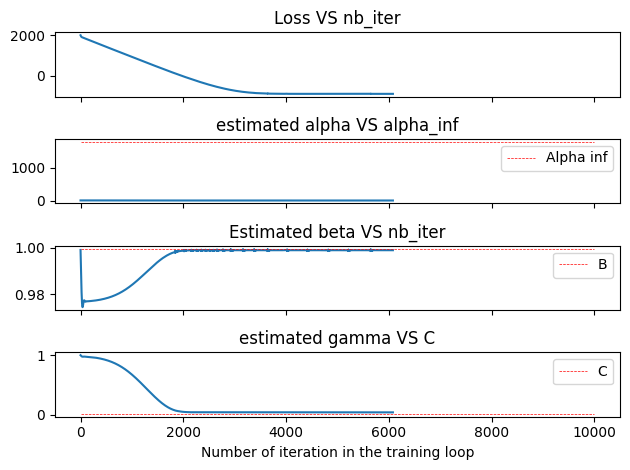

In [292]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_alpha)
axs[1].hlines(y=alpha_inf,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Alpha inf", linestyles='dashed')
axs[1].legend()
axs[1].set_title("estimated alpha VS alpha_inf")
axs[2].plot(estimated_beta)
axs[2].hlines(y=B,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="B", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated beta VS nb_iter")
axs[3].plot(estimated_gamma)
axs[3].hlines(y=C,xmin=0,xmax=n_iter,linewidth=0.5,color='r',label="C",linestyles='dashed')
axs[3].legend()
axs[3].set_title("estimated gamma VS C")
plt.xlabel("Number of iteration in the training loop")
fig.tight_layout()

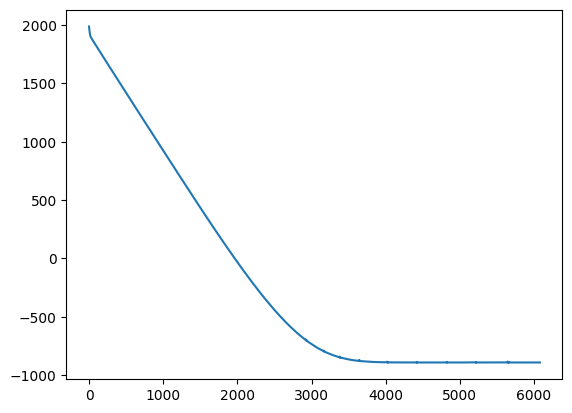

In [293]:
plt.plot(losses_train)

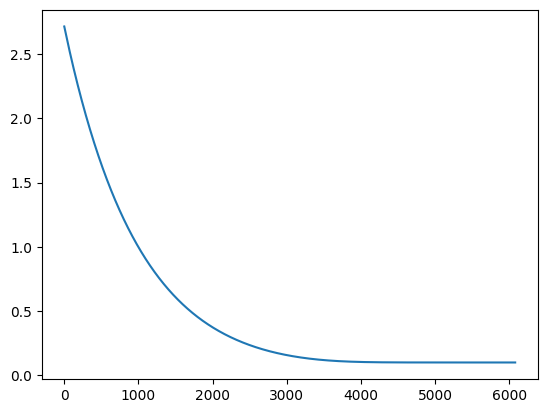

In [294]:
plt.plot(estimated_alpha)

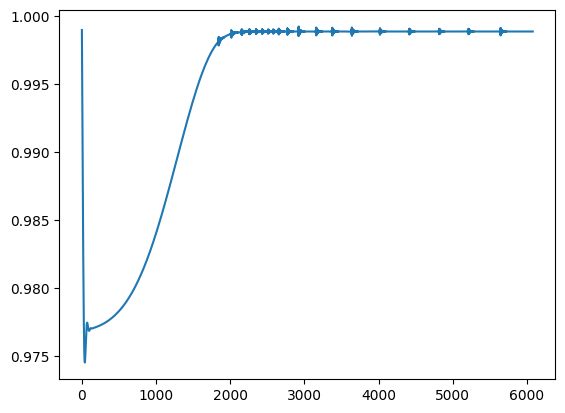

In [295]:
plt.plot(estimated_beta)

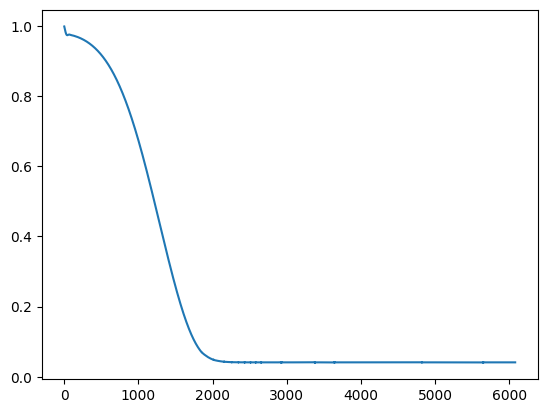

In [296]:
plt.plot(estimated_gamma)

In [297]:

C = (   mu0/(sigma0**2)  ) * ( 1/sigma0**2 + 1/sigma**2  )**(-1)
B = ( 1/sigma**2 ) * (1/sigma**2 + 1/sigma0**2 )**(-1)
A = ( 1/sigma0**2 + 1/sigma**2)**(-1/2)
alpha_inf = mu0**2 + (1 + (sigma0/sigma)**2 ) * (A**2)

In [298]:
print(f" C = {C} and gamma = {f.gamma.item()}")
print(f"B = {B} ansd beta = {f.beta.item()}")
print(f" alpha_inf = {alpha_inf} and alpha^2 estimated = {torch.exp(f.omega).item()**2}")

 C = 0.01679328268692523 and gamma = 0.04086018353700638
B = 0.9996001599360256 ansd beta = 0.9988908171653748
 alpha_inf = 1789.0 and alpha^2 estimated = 0.009852336562781228


In [299]:
def visualisation(f,N):
    fig, axs = plt.subplots(N)
    for n in range(N):
        x = generate_dataset(1)[:,0]
        m = (mu0/sigma0**2 + x/sigma**2) * (1/sigma0**2 + 1/sigma**2)**(-1)
        s2 = (1/sigma0**2 + 1/sigma**2)**(-1)
        s = np.sqrt(s2)
        true_post = torch.distributions.Normal(torch.Tensor([m]), torch.Tensor([s]))
        true_theta = true_post.sample((5000,1))

        theta_hat = f.sample(x,(5000,1))
        sns.kdeplot(true_theta.detach().numpy().flatten(), ax=axs[n],color='b')
        sns.kdeplot(theta_hat.detach().numpy().flatten(), ax=axs[n],color='g')
        axs[n].axvline(x.item(),color='r')
        axs[n].set_title(f"Estimated and true densities of theta |x, run {n}")
    blue_patch = mpatches.Patch(color='b',label="True theta distribution | x")
    green_patch = mpatches.Patch(color='g',label='Estimated distribution of theta | x')
    
    fig.legend(handles=[blue_patch,green_patch], loc='upper right', bbox_to_anchor=(1.40, 1))
    fig.tight_layout()

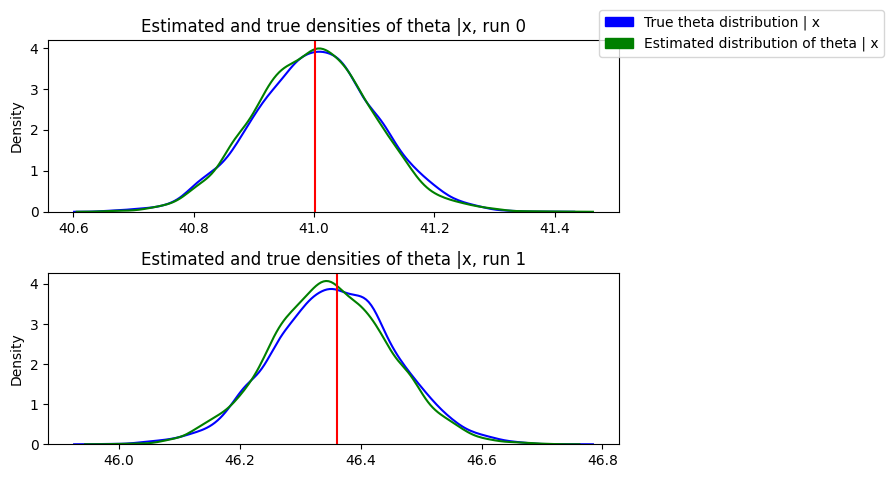

In [300]:
visualisation(f,2)

TODO Plutôt renvoyer l'objet "loi" dans forward ?